In [204]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
data_path = "../data_los"
demographics = pd.read_csv(os.path.join(data_path, "demographics_.csv"))
ehr = pd.read_csv(os.path.join(data_path, "EHR_data.csv"))

# Part 1 - Exploration
- What is the data we are working with?
- Are there any obvious considerations to make?
- Missing / dirty data?
- any features to engineer?

# Summary of exploration
- 100 people and 762 admissions over 4 years
- 8 features of the data
- age at admission, date of admission, admission code, how they got there, respiratory rate

Considerations:

- how to fill the missing values
    - i will fill the arrived_by with a random choice between 'ambulance' and 'self-presented' with the same distribution as is shown in the data eg. 60% self presented, 40% ambulance
    - for respiratory rate I will replace with the median value - there are more sophisticated ways to impute data but often it requires more domain knowledge


- How to deal with the seasonality of the number of admissions vs date

- Should I introduce a new feature that is the number of admissions of this patient to date? (Or is this more misleading because I'm not sure how this sample was selected - if we had full hospital records of all local hospitals this would probably be a useful measure, but unlikely to be in this sample.


- Are all comorbitities the same? I suppose I have no choice but to assume so


- I assume the post codes have some structure eg. G513 is close to G511 and far from G129 but, this is not always true. It would be interesting to get longitude and latitude data for each post code maybe. I think for now I will treat the post codes as being a discrete variable as im not sure of the relations between them and not sure how to get this info easily but it would be interesting to explore this differently.
   
   
- How to split the data? 
    - Its a relatively small data set so lets so 70, 10, 20 for train, test, validation.
    - Split by group so that we are not training and testing on the same people eg. if you are in the training set you will not be in the test or validation
    - So this makes it easy because i will just split on patient id not admission_id
 
 
- I will treat this as a multiple univariate regression problem and keep the target variable continuous. The target variable is gaussian distributed. I would maybe explore some method of balancing or smoothing the target variable to avoid bias caused by overrepresentation of the middle values. But not for this as I probably wont have time.

- I will use the rmse from the predicted length of stay to the actual length of stay. If this were a real project, it would be good to understand the current process. For instance, is there some person or people in the emergency department that predict length of stay? If so, it would be prefereable to compare the system to their performance either on this same data set, or just in general have an idea of the average error they get to put the rmse of this model in context. No prediction model will be perfect so it is often more useful to measure the improvement the model provides to the current process. 

In [164]:
demographics.head()

,id,dob,comorb,post,dob_datetime
0,59,22/05/1955,5,G129,1955-05-22
1,84,11/03/1959,6,G129,1959-11-03
2,55,02/10/1953,5,G129,1953-02-10
3,91,26/06/1945,6,G129,1945-06-26
4,49,06/09/1957,6,G208,1957-06-09


In [165]:
ehr.head()

,id,adm_date,adm_code,arrived_by,respiratory_rate,length_stay,adm_datetime
0,1,2016-02-23,7,Ambulance,NaN,5,2016-02-23
1,1,2017-12-14,9,NaN,10.0,6,2017-12-14
2,1,2018-01-05,5,self presented,20.0,8,2018-01-05
3,1,2019-11-27,4,self presented,NaN,8,2019-11-27
4,1,2019-08-29,10,self presented,16.0,3,2019-08-29


In [166]:
demographics.isnull().values.any()

False

In [167]:
ehr.isnull().values.any()

True

In [168]:
ehr.isnull().any()

id                  False
adm_date            False
adm_code            False
arrived_by           True
respiratory_rate     True
length_stay         False
adm_datetime        False
dtype: bool

In [169]:
ehr[ehr.isnull().any(axis=1)]

,id,adm_date,adm_code,arrived_by,respiratory_rate,length_stay,adm_datetime
0,1,2016-02-23,7,Ambulance,NaN,5,2016-02-23
1,1,2017-12-14,9,NaN,10.0,6,2017-12-14
3,1,2019-11-27,4,self presented,NaN,8,2019-11-27
6,1,2019-10-24,5,NaN,17.0,8,2019-10-24
7,2,2016-12-17,7,self presented,NaN,11,2016-12-17
...,...,...,...,...,...,...,...
750,99,2017-03-10,4,Ambulance,NaN,8,2017-03-10
752,99,2017-01-25,5,Ambulance,NaN,10,2017-01-25
754,99,2019-09-16,5,self presented,NaN,7,2019-09-16
757,99,2019-11-11,5,NaN,NaN,9,2019-11-11


In [9]:
ehr[ehr.arrived_by.isnull()].shape[0]

133

In [10]:
ehr[ehr.respiratory_rate.isnull()].shape[0]

83

In [11]:
# How many people are affected by this?

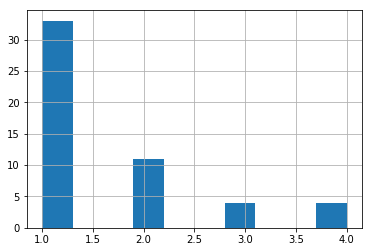

In [12]:
ehr[ehr.respiratory_rate.isnull()].groupby(['id']).size().hist()

Too many null values to remove - will have to think on how best to fill these or what else to do with them

In [14]:
# How many patients are there?
print("We have", demographics.id.nunique(), " patients and ", ehr.shape[0], "admissions")

We have 100  patients and  762 admissions


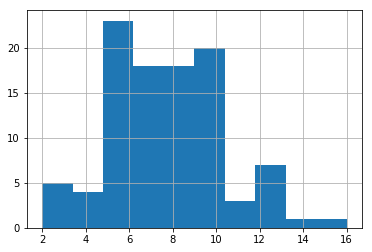

In [15]:
# How many admissions per patient?
ehr.groupby(['id']).size().hist()

In [16]:
# So not too uneven

In [17]:
ehr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                762 non-null    int64  
 1   adm_date          762 non-null    object 
 2   adm_code          762 non-null    int64  
 3   arrived_by        629 non-null    object 
 4   respiratory_rate  679 non-null    float64
 5   length_stay       762 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 35.8+ KB


In [18]:
# What time frame are we looking at

In [19]:
type(ehr.adm_date.iloc[0])

str

In [20]:
# Make it a datetime

In [21]:
ehr['adm_datetime'] = pd.to_datetime(ehr.adm_date)

(array([735933., 736116., 736299., 736481., 736664., 736846., 737029.,
        737211., 737394.]),
 <a list of 9 Text xticklabel objects>)

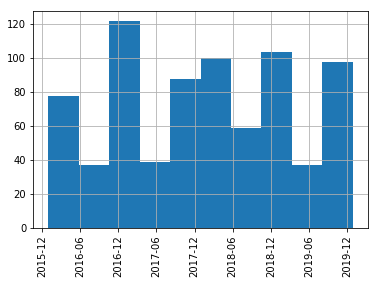

In [22]:
ehr['adm_datetime'].hist()
plt.xticks(rotation=90)

Ok so
- there is some seasonality here with winters having more admissions
- we have data over 4 years

In [23]:
ehr.adm_code.value_counts()

7     84
3     82
6     80
2     80
4     79
8     77
5     74
1     74
9     67
10    65
Name: adm_code, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120091f10>,
      dtype=object)

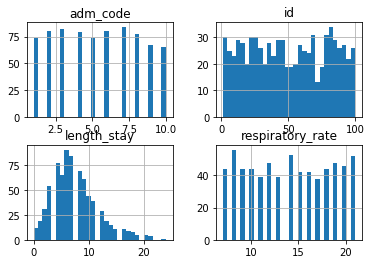

In [60]:
ehr.hist(bins=30)

In [27]:
demographics['dob_datetime'] = pd.to_datetime(demographics.dob)

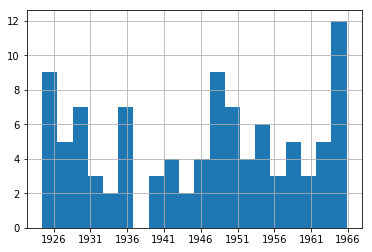

In [54]:
demographics.dob_datetime.hist(bins=20)

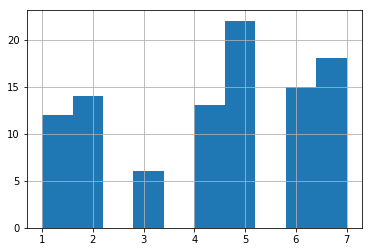

In [52]:
demographics.comorb.hist(bins=10)

In [30]:
demographics.post.value_counts()

G411     8
G536     8
G776     7
G349     5
G459     5
G332     5
G521     5
G212     5
PA191    5
G208     4
G466     4
G226     4
G824     4
G129     4
G511     3
PA146    3
G326     3
G513     3
PA34     3
PA167    3
PA33     2
G667     2
G329     2
G333     2
G697     1
Name: post, dtype: int64

What I don't know:
- Are all comorbitities the same? I suppose I have no choice but to 
- I assume the post codes have some structure eg. G513 is close to G511 and far from G129 but, this is not always true. I think for now I will treat the post codes as being a discrete variable as im not sure of the relations between them and not sure how to get this info easily but it would be interesting to explore this differently


In [83]:
# Lets merge the datasets
df = pd.merge(demographics, ehr, on='id', how = "inner")

In [35]:
df.shape, ehr.shape

((762, 11), (762, 7))

In [38]:
df.columns

Index(['id', 'dob', 'comorb', 'post', 'dob_datetime', 'adm_date', 'adm_code',
       'arrived_by', 'respiratory_rate', 'length_stay', 'adm_datetime'],
      dtype='object')

### Split out test set
Before I look any more I want to split out a test set to avoid any more data snooping bias!
How could I do this? 

- In the real world, I would want to understand if this data has been collected via random sampling or if not, how was it selected. 
- I would also want to have a bit more domain knowledge to understand whether it is known that some of these features are particularly important
- perhaps I would stratify my sampling of the test set by splitting this into categories for example ensure a representative distribution of 

But, for this exercise I will just randomly choose a test set but ensuring to keep a person in either the train or the test set, but not in both. 

In [86]:
from sklearn.model_selection import train_test_split

In [147]:
def train_test_split_patientgroup(data, test_ratio, patient_id_column, random_state = 42):
    # set seed
    np.random.seed(random_state)
    
    # Shuffle and select patient ids
    ids = data[patient_id_column].unique()
    shuffled_patient_ids = np.random.permutation(ids)
    test_set_size = int(test_ratio * len(ids))
    test_patient_ids = shuffled_patient_ids[:test_set_size]
    train_patient_ids = shuffled_patient_ids[test_set_size:]
    
    # Return train dataframe with test patients, and test df with test patients
    test_data = data.loc[data[patient_id_column].isin(test_patient_ids)]
    train_data = data.loc[data[patient_id_column].isin(train_patient_ids)]
    
    # Lets just check that we have an ok amount of data in each set
    print("percent of data in test set:", test_data.shape[0]/df.shape[0])
    
    return test_data, train_data

In [150]:
# I am going to split 20% from the set based on patient_id. 
# Some patients have more than others so we end up with 18% of data in the test set but this is fine.
test_data, train_data = train_test_split_patientgroup(df, 0.2, 'id', random_state = 42)

percent of data in test set: 0.18110236220472442


In [139]:
test_data.id.unique()

array([ 59,  49,  95, 100,  18,   8,  63,  66,  71,  72,  74,  83,  53,
        11,  12,   3,  46,  68,  80,  13])

In [186]:
train_df = train_data.copy()

# Train Set exploration

- Now that the data is split out, lets look at any correlations we might see

In [ ]:
from pandas.plotting import scatter_matrix

In [189]:
train_df.columns

Index(['id', 'dob', 'comorb', 'post', 'dob_datetime', 'adm_date', 'adm_code',
       'arrived_by', 'respiratory_rate', 'length_stay', 'adm_datetime'],
      dtype='object')

In [192]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 12 to 761
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                624 non-null    int64         
 1   dob               624 non-null    object        
 2   comorb            624 non-null    int64         
 3   post              624 non-null    object        
 4   dob_datetime      624 non-null    datetime64[ns]
 5   adm_date          624 non-null    object        
 6   adm_code          624 non-null    int64         
 7   arrived_by        515 non-null    object        
 8   respiratory_rate  557 non-null    float64       
 9   length_stay       624 non-null    int64         
 10  adm_datetime      624 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 58.5+ KB


In [193]:
# Create new feature
train_df['age_at_admission_years'] = (train_df['adm_datetime'] - train_df['dob_datetime'])/np.timedelta64(1, 'Y')

In [198]:
interesting_features = ['age_at_admission_years','comorb','adm_code','length_stay','respiratory_rate']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127f19f10>,
      dtype=object)

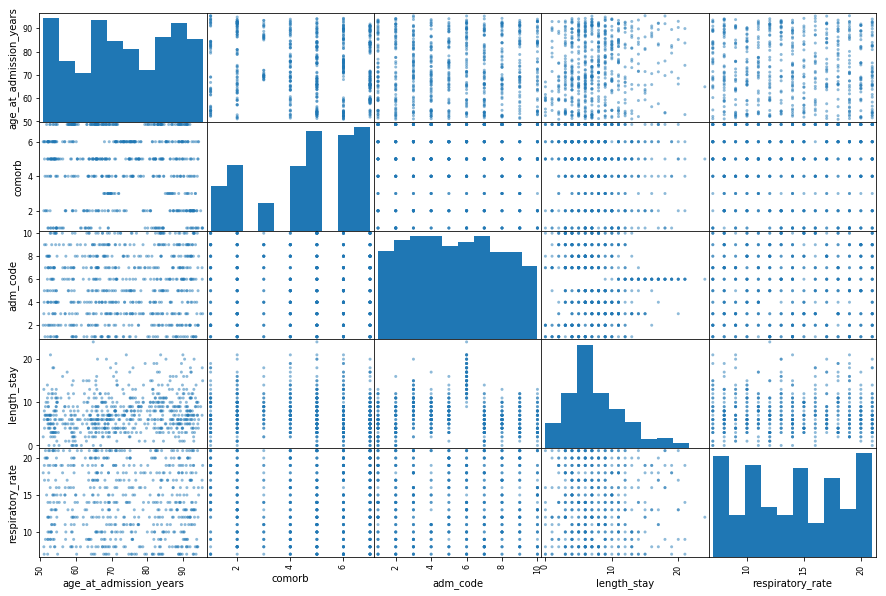

In [200]:
scatter_matrix(train_df[interesting_features], figsize = (15,10))

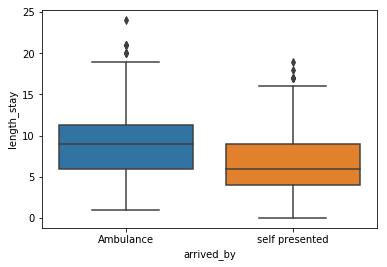

In [205]:
sns.boxplot(data = train_df, x = "arrived_by", y = "length_stay")

Notes: 
- need to encode the data appropriatley - for example comorbidities and admission codes are ordinal and categorical variables
- Actually, i'm not sure if comorbidities is ordinal - I don't want to assume a range of possible values based only on this training set. This is also where a bit of domain understanding would be helpful to properly model this
- It looks like respiratory rate is also not continuous maybe its just rounded.
- From these (very crude) plots, I can see that admission code 6 has a seemingly big impact on length of stay
- theres a hint of age and length of stay having a relationship
- Arrived by has a suggested effect from visual inspection
- It would be good to balance the target variable as its a bit tricky to see any relationships.

# Data Preprocessing
- Create new features (datetime features, age_at_admission)
- Fill null values in the arrived_by by a random choice with probabilty the same as the distribution in the non-null arrived by in the training set
- Fill the missing respiratory_rate with the median respiratory rate
- One hot encode categorical variables: post, adm_code, arrived_by
- ( as noted above - the post codes will have some ordinal type relationship, i would probably try to replace with longitude and latitude values or something, I am assuming that I have all the possible values of adm_code and arrived by in this data set but this would need verifying or clever coding)
- I am going to assume that I will only get missing values in the 'arrived by' and 'respiratory rate' variables but i could/should fit an imputer to all the variables incase incoming data has unexpected nulls 

In [206]:
# Whats the distribution of the non-
train_df.arrived_by.value_counts()/ train_df[~train_df.arrived_by.isnull()].shape[0]

self presented    0.603883
Ambulance         0.396117
Name: arrived_by, dtype: float64

In [160]:
# Create new feature
train_df['age_at_admission_years'] = (train_df['adm_datetime'] - train_df['dob_datetime'])/np.timedelta64(1, 'Y')

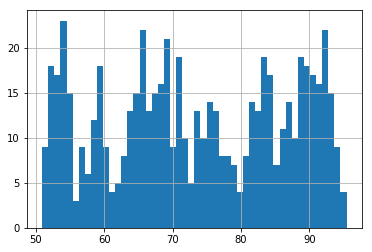

In [161]:
train_df['age_at_admission_years'].hist(bins=50)

# Train set correlation exploration

In [ ]:
from pandas.plotting import scatter_matrix

train_df.columns

scatter_matrix(train_df, figsize = (15,10))